# Comparing ECMWF and La ReUnion forecasts against La ReUnion Best Track data

This notebook looks at the two sources and compares the performance and review which cyclones would be activated historically.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from datetime import datetime
import os
import numpy as np


import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from src.datasources import codab, helpers, rsmc
from src import constants

c:\Users\pauni\Desktop\Work\OCHA\GitHub\ds-aa-moz-cyclones\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
save_dir = rsmc.DATA_DIR / "public" / "exploration" / "moz" / "ecmwf_hindcast"

In [4]:
# Complete list of storms
all_storms = [
    "FAVIO",
    "JOKWE",
    "IZILDA",
    "DANDO",
    "IRINA",
    "HARUNA",
    "DELIWE",
    "GUITO",
    "HELLEN",
    "CHEDZA",
    "DINEO",
    "DESMOND",
    "IDAI",
    "KENNETH",
    "CHALANE",
    "ELOISE",
    "GUAMBE",
    "ANA",
    "GOMBE",
    "JASMINE",
    "FREDDY",
    "FILIPO",
]
ADM2_48 = [
    "Angoche",
    "Maganja Da Costa",
    "Machanga",
    "Govuro",
]
ADM2_64 = [
    "Mogincual",
    "Namacurra",
    "Dondo",
    "Cidade Da Beira",
    "Buzi",
    "Vilankulo",
]

<Axes: >

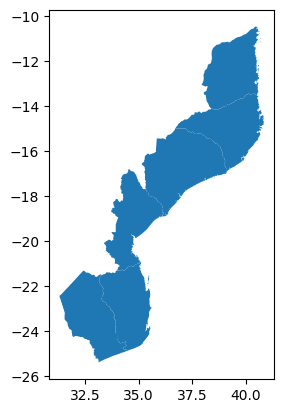

In [5]:
adm0 = codab.load_codab()
adm = adm0[adm0["ADM1_PT"].isin(constants.ADMS)]
adm.plot()

<Axes: >

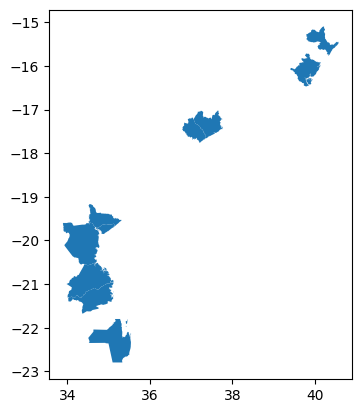

In [6]:
adm2_path = (
    rsmc.DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)

adm2 = gpd.read_file(adm2_path)
adm2_sel = adm2[adm2["ADM2_PT"].isin(constants.ADMS2)]
adm2_sel.plot()

In [7]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [8]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)

In [9]:
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)

In [10]:
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)

<Axes: >

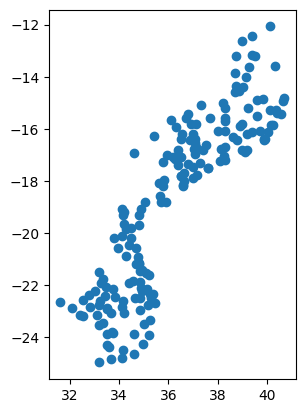

In [11]:
cyclone_tracks_sel.plot()

In [12]:
cyclone_tracks_sel["Name"].unique()

array(['FILAO', 'DESSILIA', 'NADIA', 'BONITA', 'LISETTE', 'A19798',
       'ASTRIDE', 'ELINE', 'GLORIA', 'HUDAH', 'DELFINA', 'JAPHET',
       '720052006', 'FAVIO', 'JAYA', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA',
       'HARUNA', 'DELIWE', '920132014', 'GUITO', 'HELLEN', 'CHEDZA',
       'DINEO', '420172018', 'DESMOND', 'IDAI', 'KENNETH', 'CHALANE',
       'ELOISE', 'GUAMBE', 'ANA', 'DUMAKO', 'GOMBE', 'JASMINE', 'FREDDY'],
      dtype=object)

In [13]:
df = rsmc.load_historical_forecast_distances()

In [14]:
ibtracs_path = rsmc.DATA_DIR / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)

In [15]:
gdf_points["Date"] = [
    datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").date()
    for dt in gdf_points["ISO_TIME"]
]

gdf_points["REU_USA_WIND"] = gdf_points["REU_WIND"].fillna(
    gdf_points["USA_WIND"] * 0.88
)
gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])

In [16]:
df = df[df["name"].isin(all_storms)]

La ReUnion forecasts vs Best Track Data

In [17]:
df.columns

Index(['valid_time', 'lt_hour', 'latitude', 'longitude', 'max_wind_kt',
       'season', 'name', 'numberseason', 'issue_time', 'MZ03_distance_km',
       'MZ07_distance_km', 'MZ09_distance_km', 'MZ11_distance_km'],
      dtype='object')

### ECMWF

Adding which cyclones would be triggered using ECMWF

In [18]:
ecmwf_cyclone_data = helpers.load_all_cyclone_csvs(save_dir)
ecmwf_cyclone_data["lat"] = ecmwf_cyclone_data["lat"].apply(
    lambda x: -x if x > 0 else x
)
interpolated_ecmwf_data = helpers.interpolate_cyclone_tracks(
    ecmwf_cyclone_data
)

In [19]:
ecmwf_cyclone_gdf = gpd.GeoDataFrame(
    ecmwf_cyclone_data,
    geometry=gpd.points_from_xy(
        ecmwf_cyclone_data.lon, ecmwf_cyclone_data.lat
    ),
    crs="EPSG:4326",  # Assuming WGS84
)
ecmwf_cyclones_on_land = gpd.sjoin(
    ecmwf_cyclone_gdf, adm2_sel, how="inner", predicate="intersects"
)
ecmwf_cyclones_on_land_obs = gpd.sjoin(
    ecmwf_cyclone_gdf, adm, how="inner", predicate="intersects"
)

In [20]:
# readiness
readiness_storms = ecmwf_cyclones_on_land[
    ((ecmwf_cyclones_on_land["lead_time"] > 72))
    & (ecmwf_cyclones_on_land["speed"] >= (48 * 0.514444))
]["cyclone_name"].unique()
readiness_storms

array(['FAVIO', 'IZILDA', 'IDAI', 'CHALANE', 'ELOISE', 'GOMBE', 'FREDDY'],
      dtype=object)

In [21]:
# action
action_storms = ecmwf_cyclones_on_land[
    ((ecmwf_cyclones_on_land["lead_time"] >= 6))
    & (ecmwf_cyclones_on_land["lead_time"] <= 72)
    & (ecmwf_cyclones_on_land["speed"] >= (48 * 0.514444))
]["cyclone_name"].unique()
action_storms

array(['FAVIO', 'JOKWE', 'IDAI', 'CHALANE', 'ELOISE', 'GOMBE', 'FREDDY',
       'FILIPO'], dtype=object)

In [22]:
# observational
obs_ws_storms = ecmwf_cyclones_on_land_obs[
    ((ecmwf_cyclones_on_land_obs["lead_time"] == 0))
    & (ecmwf_cyclones_on_land_obs["speed"] >= (48 * 0.514444))
]["cyclone_name"].unique()
obs_ws_storms

array(['IDAI', 'ANA', 'FREDDY'], dtype=object)

In [23]:
interpolated_ecmwf_data[
    (interpolated_ecmwf_data["cyclone_name"] == "FREDDY")
    & (interpolated_ecmwf_data["speed"] >= 48 * 0.514444)
]

,time,forecast_time,speed,lat,lon,lead_time,cyclone_name
10371,2023-03-04 21:30:00+00:00,"2023/03/02, 12:00:0",24.700,-22.075000,40.833333,52.5,FREDDY
10372,2023-03-04 22:00:00+00:00,"2023/03/02, 12:00:0",25.000,-22.100000,40.866667,54.0,FREDDY
10373,2023-03-04 22:30:00+00:00,"2023/03/02, 12:00:0",25.300,-22.125000,40.900000,55.5,FREDDY
10374,2023-03-04 23:00:00+00:00,"2023/03/02, 12:00:0",25.600,-22.150000,40.933333,57.0,FREDDY
10375,2023-03-04 23:30:00+00:00,"2023/03/02, 12:00:0",25.900,-22.175000,40.966667,58.5,FREDDY
...,...,...,...,...,...,...,...
11212,2023-03-22 10:00:00+00:00,"2023/03/02, 12:00:0",25.200,-32.233333,37.233333,238.0,FREDDY
11213,2023-03-22 10:30:00+00:00,"2023/03/02, 12:00:0",25.325,-32.400000,37.300000,238.5,FREDDY
11214,2023-03-22 11:00:00+00:00,"2023/03/02, 12:00:0",25.450,-32.566667,37.366667,239.0,FREDDY
11215,2023-03-22 11:30:00+00:00,"2023/03/02, 12:00:0",25.575,-32.733333,37.433333,239.5,FREDDY


In [24]:
# Lists of storm events
df = pd.DataFrame(
    {
        "storm": all_storms,
        "Total Affected": [
            162770,
            220013,
            7103,
            40042,
            4958,
            None,
            None,
            None,
            None,
            None,
            750102,
            None,
            1628167,
            400094,
            73254,
            481901,
            None,
            185429,
            736015,
            None,
            1143569,
            50781,
        ],
        "CERF Allocations": [
            1070014,
            548913,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            2000095,
            None,
            14018121,
            9964907,
            None,
            None,
            None,
            None,
            4018682,
            None,
            9995213,
            None,
        ],
    }
)
df["Readiness"] = [storm in readiness_storms for storm in all_storms]
df["Action"] = [storm in action_storms for storm in all_storms]
df["Observational Wind Speed"] = [
    storm in obs_ws_storms for storm in all_storms
]
df = df[
    [
        "storm",
        "Readiness",
        "Action",
        "Observational Wind Speed",
        "Total Affected",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected", ascending=False)


# Define functions for highlighting and coloring bars
def highlight_true(val):
    color = "red" if val else ""
    return f"background-color: {color}"


def color_bar_affected(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, orange {val/df_sorted["Total Affected"].max()*100}%, transparent {val/df_sorted["Total Affected"].max()*100}%);'
    return ""


def color_bar_cerf(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, green {val/df_sorted["CERF Allocations"].max()*100}%, transparent {val/df_sorted["CERF Allocations"].max()*100}%);'
    return ""


# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Readiness",
            "Action",
            # "Observational Rainfall",
            "Observational Wind Speed",
        ],
    )
    .map(color_bar_affected, subset=["Total Affected"])
    .map(color_bar_cerf, subset=["CERF Allocations"])
    .format(
        {
            "Total Affected": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

# Display the styled DataFrame
styled_df

,storm,Readiness,Action,Observational Wind Speed,Total Affected,CERF Allocations
12,IDAI,True,True,True,"1,628,167","14,018,121"
20,FREDDY,True,True,True,"1,143,569","9,995,213"
10,DINEO,False,False,False,"750,102","2,000,095"
18,GOMBE,True,True,False,"736,015","4,018,682"
15,ELOISE,True,True,False,"481,901",
13,KENNETH,False,False,False,"400,094","9,964,907"
1,JOKWE,False,True,False,"220,013","548,913"
17,ANA,False,False,True,"185,429",
0,FAVIO,True,True,False,"162,770","1,070,014"
14,CHALANE,True,True,False,"73,254",


### Meteo-France La Reunion

Adding which cyclones would be triggered using La ReUnion

In [25]:
df_rsmc_dist = rsmc.load_historical_forecast_distances()

In [26]:
df_rsmc = pd.read_parquet(
    rsmc.DATA_DIR
    / "private"
    / "processed"
    / "moz"
    / "rsmc"
    / "rsmc_forecasts_interp_distances_withradius.parquet"
)

In [27]:
# adding buffer
df_rsmc["radius_max_wind_km"] = (
    df_rsmc["radius_max_wind_nm"].astype(float) * 1.852
)

In [28]:
mf_lr_gdf = gpd.GeoDataFrame(
    df_rsmc,
    geometry=gpd.points_from_xy(df_rsmc.longitude, df_rsmc.latitude),
    crs="EPSG:4326",  # Assuming WGS84
)

In [29]:
# Fill missing values and avoid zeroes in 'radius_max_wind_km'
mf_lr_gdf_buffer = mf_lr_gdf.copy()
mf_lr_gdf_buffer["radius_max_wind_km"] = (
    mf_lr_gdf_buffer["radius_max_wind_km"].fillna(0.001).replace(0, 0.001)
)

# Reproject to a CRS that supports meters (e.g., EPSG:3857)
mf_lr_gdf_buffer = mf_lr_gdf_buffer.to_crs(epsg=3857)

# Apply the buffer using the 'radius_max_wind_km' (converting to meters)
mf_lr_gdf_buffer["geometry"] = mf_lr_gdf_buffer.geometry.buffer(
    mf_lr_gdf_buffer["radius_max_wind_km"] * 1000  # Convert km to meters
)

# Reproject back to the original CRS
mf_lr_gdf_buffer = mf_lr_gdf_buffer.to_crs(mf_lr_gdf.crs)

In [30]:
mf_lr_on_land_adm0 = gpd.sjoin(
    mf_lr_gdf_buffer, adm0, how="inner", predicate="intersects"
)
mf_lr_on_land_adm1 = gpd.sjoin(
    mf_lr_gdf_buffer, adm, how="inner", predicate="intersects"
)
mf_lr_on_land_adm2 = gpd.sjoin(
    mf_lr_gdf, adm2_sel, how="inner", predicate="intersects"
)
mf_lr_on_land_adm2_buffer = gpd.sjoin(
    mf_lr_gdf_buffer, adm2_sel, how="inner", predicate="intersects"
)

In [31]:
mf_lr_on_land_adm1["name"].unique()  # cyclones that made it to land

array(['ANA', '0420172018', 'CHALANE', 'DUMAKO', 'DINEO', 'DANDO',
       'DESMOND', 'ELOISE', 'FREDDY', 'FUNSO', 'FILIPO', 'GIOVANNA',
       '0920132014', 'GOMBE', 'IRINA', 'IDAI', 'JASMINE', 'HELLEN',
       'KENNETH'], dtype=object)

In [32]:
# readiness
buffer = True
if buffer:
    mf_lr_on_land_adm2_df = mf_lr_on_land_adm2_buffer
else:
    mf_lr_on_land_adm2_df = mf_lr_on_land_adm2

In [ ]:
# readiness
# Get storms that meet the thresholds
#readiness_storms = mf_lr_on_land_adm1[
#    ((mf_lr_on_land_adm1["lt_hour"] > 72))
#    & (mf_lr_on_land_adm1["max_wind_kt"] >= (64))
#]["name"].unique()
#readiness_storms

array(['ELOISE', 'FREDDY', 'FUNSO', 'GOMBE', 'IRINA', 'IDAI', 'HELLEN',
       'KENNETH'], dtype=object)

In [73]:
# readiness
# Get storms that meet the thresholds
readiness_storms = mf_lr_on_land_adm2_df[
    (mf_lr_on_land_adm2_df["lt_hour"] > 72)
    & (
        (mf_lr_on_land_adm2_df["max_wind_kt"] >= 48)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_48))
        | (mf_lr_on_land_adm2_df["max_wind_kt"] >= 64)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_64))
    )
]["name"].unique()
readiness_storms

array(['CHALANE', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI'], dtype=object)

In [74]:
# action
action_storms = mf_lr_on_land_adm2_df[
    ((mf_lr_on_land_adm2_df["lt_hour"] >= 6))
    & (mf_lr_on_land_adm2_df["lt_hour"] <= 72)
    & (
        (mf_lr_on_land_adm2_df["max_wind_kt"] >= 48)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_48))
        | (mf_lr_on_land_adm2_df["max_wind_kt"] >= 64)
        & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_64))
    )
]["name"].unique()
action_storms

array(['ELOISE', 'FREDDY', 'GOMBE', 'IDAI'], dtype=object)

In [75]:
# action_storms = mf_lr_on_land_adm2_df[
#    ((mf_lr_on_land_adm2_df["lt_hour"] > 6))
#    & (mf_lr_on_land_adm2_df["lt_hour"] <= 72)
#    & (mf_lr_on_land_adm2["max_wind_kt"] >= (64))
# ]["name"].unique()
# action_storms

In [76]:
# observational
obs_ws_storms = mf_lr_on_land_adm0[
    ((mf_lr_on_land_adm0["lt_hour"] == 0))
    & (mf_lr_on_land_adm0["max_wind_kt"] >= (64))
]["name"].unique()
obs_ws_storms

array(['DINEO', 'ELOISE', 'FREDDY', 'GOMBE', 'IDAI', 'KENNETH'],
      dtype=object)

In [77]:
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_points = gpd.read_file(points_path)
gdf_points_sel = gpd.sjoin(
    gdf_points, adm, how="inner", predicate="intersects"
)
gdf_points_sel_ = gdf_points_sel[
    [
        "ADM1_PT",
        "NAME",
        "ISO_TIME",
        "REU_WIND",
        "WMO_WIND",
        "USA_WIND",
        "geometry",
    ]
].sort_values("ISO_TIME")
gdf_points_sel_[
    (gdf_points_sel_["REU_WIND"] >= 64)
    & (gdf_points_sel_["ISO_TIME"] >= "1998")
]

,ADM1_PT,NAME,ISO_TIME,REU_WIND,WMO_WIND,USA_WIND,geometry
132804,Sofala,ELINE:LEONE,2000-02-22 09:00:00,88.0,NaN,103.0,POINT (34.5 -20.5)
132805,Sofala,ELINE:LEONE,2000-02-22 12:00:00,75.0,75.0,90.0,POINT (34 -20.3)
133658,Zambezia,HUDAH,2000-04-08 06:00:00,65.0,65.0,80.0,POINT (38.3 -17.2)
138290,Inhambane,JAPHET,2003-03-02 18:00:00,70.0,70.0,85.0,POINT (35.1 -21.7)
143668,Inhambane,FAVIO,2007-02-22 12:00:00,90.0,90.0,90.0,POINT (35.1 -21.7)
143669,Inhambane,FAVIO,2007-02-22 15:00:00,78.0,NaN,85.0,POINT (34.9 -21.3)
143670,Sofala,FAVIO,2007-02-22 18:00:00,65.0,65.0,80.0,POINT (34.7 -20.9)
145802,Nampula,JOKWE,2008-03-08 18:00:00,75.0,75.0,85.0,POINT (40 -16.2)
145803,Nampula,JOKWE,2008-03-08 21:00:00,70.0,NaN,83.0,POINT (39.8 -16.4)
156746,Inhambane,DINEO,2017-02-15 18:00:00,75.0,75.0,75.0,POINT (35.3 -23.4)


In [78]:
obs_ws_storms = gdf_points_sel_[
    (gdf_points_sel_["REU_WIND"] >= 64)
    & (gdf_points_sel_["ISO_TIME"] >= "1998")
]["NAME"].unique()
obs_ws_storms

array(['ELINE:LEONE', 'HUDAH', 'JAPHET', 'FAVIO', 'JOKWE', 'DINEO',
       'IDAI', 'KENNETH', 'ELOISE'], dtype=object)

In [79]:
# observational
# obs_ws_storms = np.array(
#    [
#        "ANGELE",
#        "ELINE:LEONE",
#        "HUDAH",
#        "JAPHET",
#        "FAVIO",
#        "JOKWE",
#        "DINEO",
#        "IDAI",
#        "KENNETH",
#        "ELOISE",
#    ],
#    dtype=object,
# )
# obs_ws_storms

In [80]:
# obs_ws_storms = cyclone_tracks_sel[cyclone_tracks_sel["Max wind (kt)"] >= 64][
#    "Name"
# ].unique()

In [81]:
# rain_df = pd.read_csv(
#    rsmc.DATA_DIR
#    / "public"
#    / "processed"
#    / "moz"
#    / "daily_imerg_cyclone_landfall_fixed.csv"
# )

In [82]:
# imerg_data = rain_df[(rain_df["radius"] == 250)]
# imerg_df = imerg_data[
#    imerg_data["time_step"].isin([-1, 0, 1])
# ].copy()  # Create a copy to avoid warnings
# Ensure 'date' is in datetime format
# imerg_df["date"] = pd.to_datetime(imerg_df["date"], format="%d/%m/%Y %H:%M")
# Create month_year column
# imerg_df["year_month"] = imerg_df["date"].dt.to_period("M")
# imerg_sum_df = (
#    imerg_df.groupby(["storm", "year_month"])["median_precip"]
#    .sum()
#    .reset_index()
# )

# obs_rain_storms = imerg_sum_df[imerg_sum_df["median_precip"] > 50][
#    "storm"
# ].unique()
# rename IDAI 1 to IDAI
# obs_rain_storms[obs_rain_storms == "IDAI 1"] = "IDAI"
# obs_rain_storms

In [83]:
obs_rain_storms = np.array(
    [
        "FREDDY",
        "KENNETH",
        "GOMBE",
        "IDAI",
        "JAPHET",
        "DESMOND",
        "ANA",
    ]
)

In [84]:
# Lists of storm events
df["Readiness"] = [storm in readiness_storms for storm in all_storms]
df["Action"] = [storm in action_storms for storm in all_storms]
df["Observational Wind Speed"] = [
    storm in obs_ws_storms for storm in all_storms
]
df["Observational Rainfall"] = [
    storm in obs_rain_storms for storm in all_storms
]
df = df[
    [
        "storm",
        "Readiness",
        "Action",
        "Observational Wind Speed",
        "Observational Rainfall",
        "Total Affected",
        "CERF Allocations",
    ]
]

# Sort the DataFrame by 'Total Affected' in descending order
# Round values in 'Total Affected' and 'CERF Allocations' columns
df_sorted = df.sort_values(by="Total Affected", ascending=False)


# Define functions for highlighting and coloring bars
def highlight_true(val):
    color = "red" if val else ""
    return f"background-color: {color}"


def color_bar_affected(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, orange {val/df_sorted["Total Affected"].max()*100}%, transparent {val/df_sorted["Total Affected"].max()*100}%);'
    return ""


def color_bar_cerf(val):
    if isinstance(val, (int, float)) and not pd.isna(val):
        return f'background: linear-gradient(90deg, green {val/df_sorted["CERF Allocations"].max()*100}%, transparent {val/df_sorted["CERF Allocations"].max()*100}%);'
    return ""


# Apply styling
styled_df = (
    df_sorted.style.map(
        highlight_true,
        subset=[
            "Readiness",
            "Action",
            "Observational Wind Speed",
            "Observational Rainfall",
        ],
    )
    .map(color_bar_affected, subset=["Total Affected"])
    .map(color_bar_cerf, subset=["CERF Allocations"])
    .format(
        {
            "Total Affected": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
            "CERF Allocations": lambda x: (
                f"{int(x):,}" if pd.notna(x) else ""
            ),  # Format with commas, no decimals, NaN as blank
        }
    )
    .set_table_styles(
        {"": [{"selector": "table", "props": "background-color: white;"}]}
    )
)

# Display the styled DataFrame
styled_df

,storm,Readiness,Action,Observational Wind Speed,Observational Rainfall,Total Affected,CERF Allocations
12,IDAI,True,True,True,True,"1,628,167","14,018,121"
20,FREDDY,True,True,False,True,"1,143,569","9,995,213"
10,DINEO,False,False,True,False,"750,102","2,000,095"
18,GOMBE,True,True,False,True,"736,015","4,018,682"
15,ELOISE,True,True,True,False,"481,901",
13,KENNETH,False,False,True,True,"400,094","9,964,907"
1,JOKWE,False,False,True,False,"220,013","548,913"
17,ANA,False,False,False,True,"185,429",
0,FAVIO,False,False,True,False,"162,770","1,070,014"
14,CHALANE,True,False,False,False,"73,254",


In [85]:
# checking which months and years each trigger would have been met
# readiness
readiness_trigger_years = (
    mf_lr_on_land_adm2_df[
        ((mf_lr_on_land_adm2_df["lt_hour"] > 72))
        & (
            (mf_lr_on_land_adm2_df["max_wind_kt"] >= 48)
            & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_48))
            | (mf_lr_on_land_adm2_df["max_wind_kt"] >= 64)
            & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_64))
        )
    ]["valid_time"]
    .dt.tz_localize(None)  # Remove timezone information
    .dt.to_period("M")
    .unique()
)
readiness_trigger_years

<PeriodArray>
['2020-12', '2021-01', '2023-02', '2023-03', '2022-03', '2019-03']
Length: 6, dtype: period[M]

In [86]:
# action
action_trigger_years = (
    mf_lr_on_land_adm2_df[
        ((mf_lr_on_land_adm2_df["lt_hour"] >= 0))
        & (mf_lr_on_land_adm2_df["lt_hour"] <= 72)
        & (
            (mf_lr_on_land_adm2_df["max_wind_kt"] >= 48)
            & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_48))
            | (mf_lr_on_land_adm2_df["max_wind_kt"] >= 64)
            & (mf_lr_on_land_adm2_df["ADM2_PT"].isin(ADM2_64))
        )
    ]["valid_time"]
    .dt.tz_localize(None)  # Remove timezone information
    .dt.to_period("M")
    .unique()
)
action_trigger_years

<PeriodArray>
['2021-01', '2023-02', '2023-03', '2024-03', '2022-03', '2019-03']
Length: 6, dtype: period[M]

In [87]:
# observational
obs_ws_trigger_years = (
    mf_lr_on_land_adm1[
        ((mf_lr_on_land_adm1["lt_hour"] == 0))
        & (mf_lr_on_land_adm1["max_wind_kt"] >= (48))
    ]["valid_time"]
    .dt.tz_localize(None)  # Remove timezone information
    .dt.to_period("M")
    .unique()
)
obs_ws_trigger_years

<PeriodArray>
['2017-02', '2021-01', '2023-03', '2024-03', '2022-03', '2019-03', '2019-04']
Length: 7, dtype: period[M]

In [88]:
obs_rain_trigger_years = imerg_sum_df[imerg_sum_df["median_precip"] >= 55][
    "year_month"
].unique()
obs_rain_trigger_years

<PeriodArray>
['2022-01', '2017-02', '2021-01', '2023-03', '2022-03', '2019-03', '2019-04']
Length: 7, dtype: period[M]

In [89]:
min_year_windspeed = "2010-10"
min_year_rainfall = "2003-03"
max_year_rainfall = ""

In [90]:
historical_activations = pd.DataFrame(
    {"year_month": pd.period_range(start="2000-01", end="2024-06", freq="M")}
)
historical_activations["readiness"] = historical_activations[
    "year_month"
].isin(readiness_trigger_years)
historical_activations["action"] = historical_activations["year_month"].isin(
    action_trigger_years
)
historical_activations["observational_windspeed"] = historical_activations[
    "year_month"
].isin(obs_ws_trigger_years)
historical_activations["observational_rainfall"] = historical_activations[
    "year_month"
].isin(obs_rain_trigger_years)
# Apply the date constraints
historical_activations.loc[
    historical_activations["year_month"]
    < pd.Period(min_year_windspeed, freq="M"),
    ["readiness", "action", "observational_windspeed"],
] = np.nan
historical_activations.loc[
    historical_activations["year_month"]
    < pd.Period(min_year_rainfall, freq="M"),
    "observational_rainfall",
] = np.nan

historical_activations

C:\Users\pauni\AppData\Local\Temp\ipykernel_46412\735946706.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  historical_activations.loc[
C:\Users\pauni\AppData\Local\Temp\ipykernel_46412\735946706.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  historical_activations.loc[
C:\Users\pauni\AppData\Local\Temp\ipykernel_46412\735946706.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  historical_activations.loc[
C:\Users\pauni\AppData\Local\Temp\ipykernel_46412

,year_month,readiness,action,observational_windspeed,observational_rainfall
0,2000-01,NaN,NaN,NaN,NaN
1,2000-02,NaN,NaN,NaN,NaN
2,2000-03,NaN,NaN,NaN,NaN
3,2000-04,NaN,NaN,NaN,NaN
4,2000-05,NaN,NaN,NaN,NaN
...,...,...,...,...,...
289,2024-02,False,False,False,False
290,2024-03,False,True,True,False
291,2024-04,False,False,False,False
292,2024-05,False,False,False,False


In [91]:
historical_activations.to_csv(
    rsmc.DATA_DIR / "public/processed/moz/historical_activations.csv",
    index=False,
)